In [1]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import scipy
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv

# Restrict TensorFlow to only use the first GPU
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass 

In [ ]:
"""Load dataset, normalize and split into training and testing"""

df = pd.read_csv('data.csv')
augdf = pd.read_csv('augmenteddata.csv')
df = pd.concat([df, augdf])

dataset_value_counts = df['Value'].value_counts()
print(f'Data counts: \n{dataset_value_counts}')

#Get sample dataframes of each value type
min_available_dict = df['Value'].value_counts().to_dict()
minimum_key, min_available = min(min_available_dict.items(), key= lambda x: x[1])


if minimum_key in [1.0, 2.0]:
    sample_size = min([min_available_dict.get(0.0), 2*min_available])
else: sample_size = min_available

if sample_size % 2:
    sample_size -= 1

bedEmptyDF = df.loc[df['Value'] == 0.0].sample(n= sample_size)
babyInBedDF = df.loc[(df['Value'] == 1.0) | (df['Value'] == 2.0)].sample(n= sample_size)
# babyInBedDF = df.loc[(df['Value'] == 1.0)].sample(n= sample_size//2)
# babyAsleepDF = df.loc[(df['Value'] == 2.0)].sample(n= sample_size//2)

#Combine and scramble
#combinedDF = pd.concat([bedEmptyDF, babyInBedDF, babyAsleepDF])
combinedDF = pd.concat([bedEmptyDF, babyInBedDF])
combinedDF = combinedDF.sample(frac=1).reset_index(drop=True)
training_data_counts = combinedDF['Value'].value_counts()
print(f'Training data counts: \n{training_data_counts}')
print(f'Total: {combinedDF.index.size}')

training_data = []
for i in range(len(combinedDF.index)):
    path = combinedDF.iloc[i]['ResizedPath']
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    value = combinedDF.iloc[i]['Value']
    training_data.append([image, value])
X = []
y = []
for feature, value in training_data:
    X.append(feature)
    if value in [1.0, 2.0]:
        y.append(1)
    elif value == 0.0:
        y.append(0)

# Create numpy array of images, normalize values between 0 and 1
# Reshape array (-1 unknown qty images, 135 pixels high, 240 pixels long, 1 value per pixel)
X = np.array(X)
print(f'X Shape {X.shape}')
X = X/255
X = X.reshape(-1, 135, 240,1)

# Create numpy array of output values (already 0 or 1)
# Transform to categorical. Use the number of classes as the dimension for the last dense layer in the model
y = np.array(y)
y_cat = to_categorical(y, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size= 0.1)

In [ ]:
"""View sample of training data"""

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv

plt.figure(figsize=(25,12))
for i in range(10):   
    plt.subplot(1, 10, i+1)
    plt.imshow(X[i], cmap = 'gray')
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)

In [ ]:
"""Build model"""

model = Sequential()
model.add(Conv2D(128, (3,3), input_shape= X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2,2)))

model.add(Conv2D(128, (2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2,2)))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

#model.add(Dropout(0.1))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss= 'binary_crossentropy',
                optimizer= 'adam',
                metrics= ['accuracy'])

NAME = f'SLEEPING-MODEL-{int(time.time())}'
tensorboard = TensorBoard(log_dir= f'C:\\logs\\log{NAME}')

In [ ]:
"""Fit model with imagegenerator"""
datagen = ImageDataGenerator(
                                rotation_range= 5,
                                #width_shift_range= .1,
                                #height_shift_range= .1,
                                zoom_range= 0.1, 
                                #shear_range= 0.1
                                #brightness_range= [.95, 1.05], # Causes image to scale back to 0-255
                            )
epochs = 5

divisible_by = [x for x in range(2,20) if X_train.shape[0] % x == 0]
batch_size = max(divisible_by)
print(f'Batch size: {batch_size}, {X_train.shape[0]} training images')

model.fit(
            datagen.flow(X_train, y_train, batch_size= batch_size),
            epochs= epochs,
            steps_per_epoch= X_train.shape[0] // batch_size,
            validation_data=(X_test, y_test),
            callbacks= [tensorboard]
)

In [ ]:
"""Fit model with original images"""
epochs = 5
model.fit(
            X_train, y_train,
            epochs= epochs,
            validation_data=(X_test, y_test),
            #callbacks= [tensorboard]
        )

In [ ]:
"""Save model"""
now = int(time.time())
model.save(f'models\\{now}')

Innacurate classifications:
1 of 611 images with the baby misclassified. Error rate 0.16%
16 of 228 images without baby misclassified. Error rate 7.02%


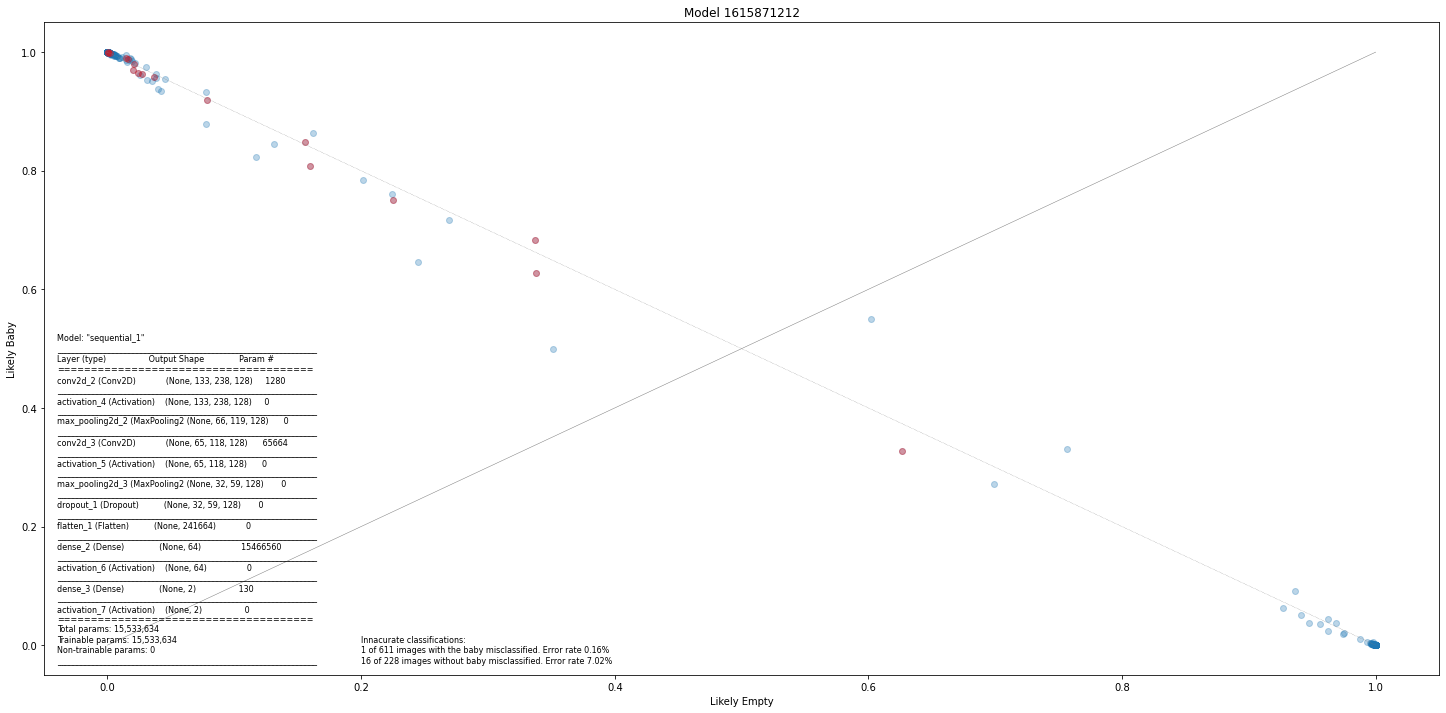

In [2]:
"""Load most recent model and make prediction on entire dataset"""

import os

current_dir = os.curdir
model_name = max(os.listdir('models'))
#model_name = '1615868331'
model_path = os.path.join(current_dir, 'models', model_name)
model = load_model(model_path)

testDF = pd.read_csv('data.csv')

validation_list = []
for i in range(len(testDF.index)):
    path = testDF.iloc[i]['ResizedPath']
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    validation_list.append(image)

V = np.array(validation_list)
V = V/255
V = V.reshape(-1,135,240,1)

validation_results = model.predict(V)
resultsDF = pd.DataFrame(validation_results, columns= ['LikelyEmpty', 'LikelyBaby'])

testDF = pd.concat([testDF, resultsDF], axis=1)

testDF['Value'] = testDF.apply(lambda row: 'Baby' if row.Value else 'No Baby', axis=1)
testDF['Prediction'] = testDF.apply(lambda row: 'Baby' if row.LikelyBaby > row.LikelyEmpty else 'No Baby', axis=1)
testDF['Incorrect'] = testDF.apply(lambda row: 1 if row.Value != row.Prediction else 0, axis=1)

baby_total = testDF.loc[(testDF['Value'] == 'Baby')].index.size
baby_incorrect = testDF.loc[(testDF['Value'] == 'Baby') & (testDF['Incorrect'] == 1)].index.size
baby_incorrect_per = round(100 * baby_incorrect / baby_total, 2)
baby_incorrect_str = f'{baby_incorrect} of {baby_total} images with the baby misclassified. Error rate {baby_incorrect_per}%'

no_baby_total = testDF.loc[(testDF['Value'] == 'No Baby')].index.size
no_baby_incorrect = testDF.loc[(testDF['Value'] == 'No Baby') & (testDF['Incorrect'] == 1)].index.size
no_baby_incorrect_per = round(100 * no_baby_incorrect / no_baby_total, 2)
no_baby_incorrect_str = f'{no_baby_incorrect} of {no_baby_total} images without baby misclassified. Error rate {no_baby_incorrect_per}%'

inaccurateDF = testDF.loc[testDF['Incorrect'] == 1].reset_index()

inaccurate_counts_message = f'Innacurate classifications:\n{baby_incorrect_str}\n{no_baby_incorrect_str}'
print(inaccurate_counts_message)

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
shitty_string = '================================================================='
stringlist = [line if line not in shitty_string else '======================================' for line in stringlist ]
short_model_summary = "\n".join(stringlist)

import matplotlib.pyplot as plt

plt.figure(figsize=(25,12))
#Plot correct predictions in blue, incorrect in red
plt.scatter(testDF['LikelyEmpty'], testDF['LikelyBaby'], alpha=.3)
plt.scatter(inaccurateDF['LikelyEmpty'], inaccurateDF['LikelyBaby'], color='red', alpha=.3)

#Plot mid-lines
plt.plot([0,1], [0,1], color='gray', lw=.5)
plt.plot([0,1], [1,0], color='gray', lw=.5, linestyle= 'dotted')

plt.xlabel('Likely Empty')
plt.ylabel('Likely Baby')
plt.title(f'Model {model_name}')
plt.text(-.04,-.03,short_model_summary, fontsize= 8)
plt.text(0.2,-.03,inaccurate_counts_message, fontsize= 8)
#plt.savefig(f'{model_path}\\{model_name}graph.png', facecolor=(1,1,1,1))
plt.show()



Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]
127.0.0.1 - - [03/May/2021 22:05:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 22:05:56] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 22:05:56] "GET /mpld3.js HTTP/1.1" 200 -

stopping Server...


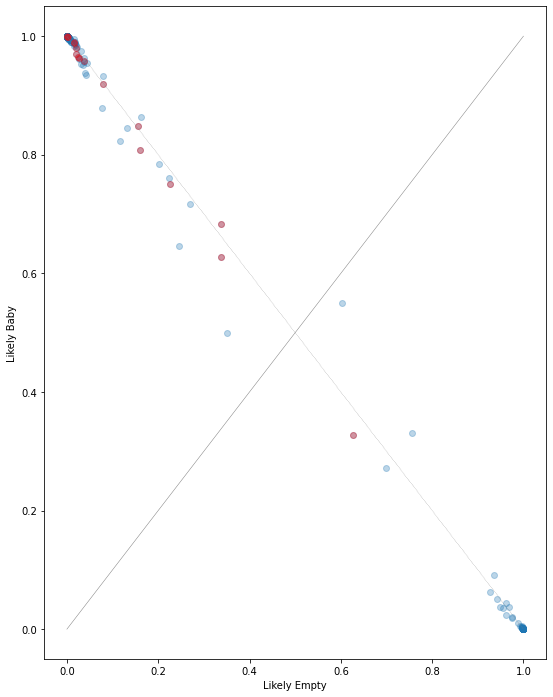

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
from urllib.request import pathname2url
class ClickInfo(mpld3.plugins.PluginBase):
    """mpld3 Plugin for getting info on click        """

    JAVASCRIPT = """
    mpld3.register_plugin("clickinfo", ClickInfo);
    ClickInfo.prototype = Object.create(mpld3.Plugin.prototype);
    ClickInfo.prototype.constructor = ClickInfo;
    ClickInfo.prototype.requiredProps = ["id", "urls"];
    function ClickInfo(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    ClickInfo.prototype.draw = function(){
        var obj = mpld3.get_element(this.props.id);
        urls = this.props.urls;
        obj.elements().on("mousedown",
                          function(d, i){ 
                            window.open(urls[i], '_blank')});
    }
    """
    def __init__(self, points, urls):
        self.points = points
        self.urls = urls
        if isinstance(points, matplotlib.lines.Line2D):
            suffix = "pts"
        else:
            suffix = None
        self.dict_ = {"type": "clickinfo",
                      "id": mpld3.utils.get_id(points, suffix),
                      "urls": urls}

#Plot correct predictions in blue, incorrect in red
fig, ax = plt.subplots(figsize= (9,12))
ax.scatter(testDF['LikelyEmpty'], testDF['LikelyBaby'], alpha=.3)
points = ax.scatter(inaccurateDF['LikelyEmpty'], inaccurateDF['LikelyBaby'], color='red', alpha=.3)
hover_photos_link = ['file:///C:'+ pathname2url(photo[2:]) for photo in inaccurateDF['ResizedPath']]


#Plot mid-lines
ax.plot([0,1], [0,1], color='gray', lw=.5)
ax.plot([0,1], [1,0], color='gray', lw=.5, linestyle= 'dotted')

ax.set_xlabel('Likely Empty')
ax.set_ylabel('Likely Baby')

#tooltip = plugins.PointHTMLTooltip(points, hover_photos_link)
plugins.connect(fig, ClickInfo(points, hover_photos_link))
mpld3.show()


In [18]:
hover_photos_link

['file://localhost/C:/Users/parki/Documents/GitHub/Python-Practice/Sleep%20Schedule/Training%20Data/Resized/20210316124044.png',
 'file://localhost/C:/Users/parki/Documents/GitHub/Python-Practice/Sleep%20Schedule/Training%20Data/Resized/20210316191412.png',
 'file://localhost/C:/Users/parki/Documents/GitHub/Python-Practice/Sleep%20Schedule/Training%20Data/Resized/20210316191414.png',
 'file://localhost/C:/Users/parki/Documents/GitHub/Python-Practice/Sleep%20Schedule/Training%20Data/Resized/20210316191421.png',
 'file://localhost/C:/Users/parki/Documents/GitHub/Python-Practice/Sleep%20Schedule/Training%20Data/Resized/20210316191423.png',
 'file://localhost/C:/Users/parki/Documents/GitHub/Python-Practice/Sleep%20Schedule/Training%20Data/Resized/20210316191429.png',
 'file://localhost/C:/Users/parki/Documents/GitHub/Python-Practice/Sleep%20Schedule/Training%20Data/Resized/20210316191431.png',
 'file://localhost/C:/Users/parki/Documents/GitHub/Python-Practice/Sleep%20Schedule/Training%20Da

In [ ]:
for i in range(1, len(inaccurateDF.index)):
    img_large = cv2.imread(inaccurateDF.at[i, 'FilePath'])
    img_small = cv2.imread(inaccurateDF.at[i, 'ResizedPath'])
    value = inaccurateDF.at[i, 'Value']
    prediction = inaccurateDF.at[i, 'Prediction']
    raw_prediction = [inaccurateDF.at[i, 'LikelyEmpty'], inaccurateDF.at[i, 'LikelyBaby']]

    cv2.putText(img = img_large,
                text = f'Value: {value}   Prediction: {prediction}   Raw: {raw_prediction}',
                org = (0, 100),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 1,
                color = (255, 255, 255),
                thickness = 2)

    cv2.imshow('Large', img_large)
    cv2.imshow('Small', img_small)
    cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
"""Display items output from generator"""

datagen = ImageDataGenerator(
                                rotation_range= 3,
                                width_shift_range= .05,
                                height_shift_range= .05,
                                zoom_range= 0.2, 
                                shear_range= 0.1
                                #brightness_range= [.95, 1.05], # Causes image to scale back to 0-255
                            )

plt.figure(figsize=(25,12))
for i in range(10):
    img, value = datagen.flow(Xaug, yaug, batch_size=1).next()
    img = img.reshape(135, 240,1)
    img = img*255
    plt.subplot(1, 10, i+1)
    plt.title(value[0])
    plt.imshow(img.astype('uint8'), cmap= 'gray')

In [ ]:
"""Generate augmented copies of all photos and save to file"""

datatoaugDF = pd.read_csv('data.csv')
Xaug = []
yaug = []
for i in range(len(datatoaugDF.index)):
    path = datatoaugDF.iloc[i]['ResizedPath']
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    value = datatoaugDF.iloc[i]['Value']
    Xaug.append(image)
    yaug.append(value)

Xaug = np.array(Xaug)
print(f'Xaug Shape {Xaug.shape}')
Xaug = Xaug/255
Xaug = Xaug.reshape(-1, 135, 240,1)

# Create numpy array of output values (already 0 or 1)
# Transform to categorical. Use the number of classes as the dimension for the last dense layer in the model
yaug = np.array(yaug)


import csv
import os
OUTPUT_DIRECTORY_AUGMENTED = 'C:\\Users\\parki\\Documents\\GitHub\\Python-Practice\\Sleep Schedule\\Training Data\\Augmented'

#Clear existing augmented files
files_list = [os.path.join(OUTPUT_DIRECTORY_AUGMENTED, file) for file in os.listdir(OUTPUT_DIRECTORY_AUGMENTED)]
for file in files_list:
    os.remove(file)

datagen = ImageDataGenerator(
                                rotation_range= 3,
                                width_shift_range= .05,
                                height_shift_range= .05,
                                zoom_range= 0.2, 
                                shear_range= 0.1
                                #brightness_range= [.95, 1.05], # Causes image to scale back to 0-255
                            )

with open('augmenteddata.csv', 'w', newline='') as f:
    csv.writer(f).writerow(['FilePath','ResizedPath','Value'])
    
    for i in range(datatoaugDF.index.size):
        img, value = datagen.flow(Xaug, yaug, batch_size=1).next()
        img = img.reshape(135, 240,1)
        img = img*255
        value = value[0]

        filename = f'augmented{i+1}.png'
        filepath = f'{OUTPUT_DIRECTORY_AUGMENTED}\\{filename}'
        cv2.imwrite(filepath, img)
        csv.writer(f).writerow(['', filepath, value])

In [ ]:
import os
OUTPUT_DIRECTORY_AUGMENTED = 'C:\\Users\\parki\\Documents\\GitHub\\Python-Practice\\Sleep Schedule\\Training Data\\Augmented'

files_list = [os.path.join(OUTPUT_DIRECTORY_AUGMENTED, file) for file in os.listdir(OUTPUT_DIRECTORY_AUGMENTED)]
for file in files_list:
    os.remove(file)